In [1]:
#This file is the original file for the 0D model, extended version with other trials
from pandas.core.api import value_counts

# Importazione dei dati

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
pd.read_excel("Parameters.xlsx", sheet_name="Foglio1")

df = pd.read_excel("Parameters.xlsx", sheet_name="Foglio1", usecols='A:E')


#Read all the rows of the dataframe and create new global variables automatically
for indice, riga in df.iterrows():
    nome_riga = riga["Symbol"]
    valore = float(riga["Converted value"])
    globals()[nome_riga] = valore

In [2]:
# Constant definition for the differential equation
plt.rc('font', size=14)
plt.rcParams['lines.linewidth'] = 2
pi = np.pi
#TPZ
K1_tpz = L_pSV * (p_t - p_L)
K2_tpz = (1 - sigma_tpz) * J_b * SV / 2
K3_tpz = P_tpz * D_tpz / (P_tpz * L + D_tpz) * (SV)
m_tpz = (K/(K + O2))*(k_met + V_max_tpz/K_m_tpz)

A_l_tpz = K1_tpz + m_tpz * phi_0 -K2_tpz + K3_tpz
B_tpz = (K2_tpz + K3_tpz)*c_v0_tpz
B_l_tpz = B_tpz
A_tpz = K1_tpz - K2_tpz + K3_tpz

print(K1_tpz)
print(K2_tpz)
print(K3_tpz)

0.00013922305764411027
1.7950200000000003e-09
0.0625374925014997


In [3]:
#Simplification of the problem, the limphatic drainage and the capillary leakage are neglected
K1_tpz = 0
K2_tpz = 0

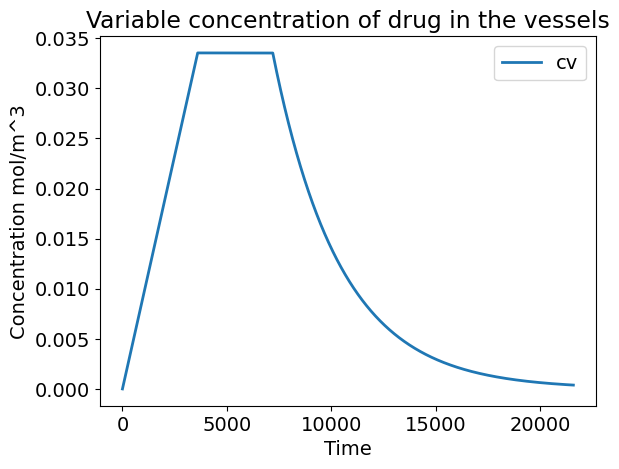

In [4]:
# Time of simulation
inizio = 0.0
fine = 21600.0 #6 ore
passo = 1 # 1s
num = int((fine - inizio) / passo) # numero di punti
time = np.linspace(inizio,fine,num) # asse temporale

# Exponential decay, elimination phase
def decay(t):
  c_v_decay = c_v0_tpz * np.exp(-t * (1/tau) )
  return c_v_decay

# Linear increase of the concentration
ca = (c_v0_tpz - 0)/3600 # cv0_tpz identified from literature

c_vv_rise = np.linspace(0, 3600, int(3600 / passo)) * ca
c_vv_const = np.ones(int(3600 / passo), dtype=float) * c_v0_tpz # constant phase
decay_time = np.linspace(0, fine - 7200, int((fine - 7200) / passo))  # exponential decay
c_vv_dec = decay(decay_time)

c_vv0 = np.concatenate([c_vv_rise, c_vv_const, c_vv_dec])
c_vv0.shape
plt.plot(time,c_vv0,label='cv') 
plt.xlabel('Time')
plt.ylabel('Concentration mol/m^3')
plt.title('Variable concentration of drug in the vessels')
plt.legend()

In [7]:
# Trying to create a two dimensional model, not used for the results
import pdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from scipy.integrate import trapz
def f(c, suma):
    dcdt = -c * (K1_tpz - K2_tpz + K3_tpz) - (K / (K + O2)) * (k_met * c + (V_max_tpz * c) / (K_m_tpz + c)) * np.exp(-alpha * suma * (K / (K + O2)) * (k_met * suma + (V_max_tpz * suma) / (K_m_tpz + suma))) * phi_0 + K2_tpz * c_v0_tpz + K3_tpz * c_v0_tpz
    return dcdt
# Parametri della griglia
Lx, Ly = 0.001, 0.001  # Dimensioni del dominio spaziale
Nx, Ny = 10, 10  # Numero di nodi nella griglia
dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)  # Passi di spazio


# Inizializzazione della griglia
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)

# Inizializzazione della funzione c
c = np.zeros((Nx, Ny, num + 1))
area = np.zeros((Nx, Ny))
aree = np.zeros((Nx, Ny, num + 1))
SF = np.ones((Nx, Ny, num + 1))
CM = np.zeros((Nx, Ny, num + 1))
flag = 0
# Iterazione temporale con il metodo delle differenze finite esplicite
for n in time:
  for i in range(1, Nx - 1):
    for j in range(1, Ny - 1):
      suma = np.sum(aree[i,j,:])
      SF[i,j,flag] = np.exp(-alpha * suma)
      laplacian_c = (c[i + 1, j,flag] - 2 * c[i, j,flag] + c[i - 1, j,flag]) / dx**2 +  (c[i, j + 1,flag] - 2 * c[i, j,flag] + c[i, j - 1,flag]) / dy**2
      #laplacian_c = 10000
      c[i, j,flag+1] = c[i, j,flag] + passo * (D_tpz * float(laplacian_c) + P_tpz * SV * (float(c_vv[flag]) - c[i, j,flag]) - c[i, j,flag] * (k_met + V_max_tpz / (K_m_tpz + c[i, j, flag]))* SF[i,j,flag] * phi_0)
      CM[i,j, flag] = c[i, j,flag] * (k_met * c[i, j,flag] + V_max_tpz * c[i, j,flag]  / (K_m_tpz + c[i, j,flag]))
      area[i, j] = ((float(CM[i,j,flag]) + float(CM[i,j,flag-1]))*float(passo))/2
      aree[i,j,flag] = area[i,j]
      #pdb.set_trace()
  flag = flag + 1







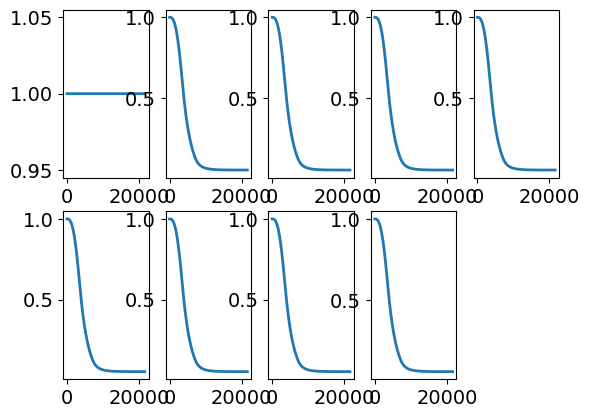

In [8]:
# SF fot the 2 dimensional model
for i in range(9):
  plt.subplot(2,5,i+1)
  plt.plot(time,SF[5,i,0:-1])

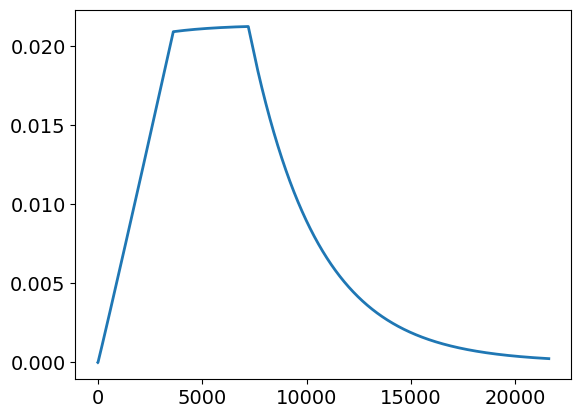

In [9]:
# ct fot the 2 dimensional model
meanc = np.zeros(num)
for i in range(num):
  meanc[i] = np.mean(c[:,:,i])

plt.plot(time,meanc)

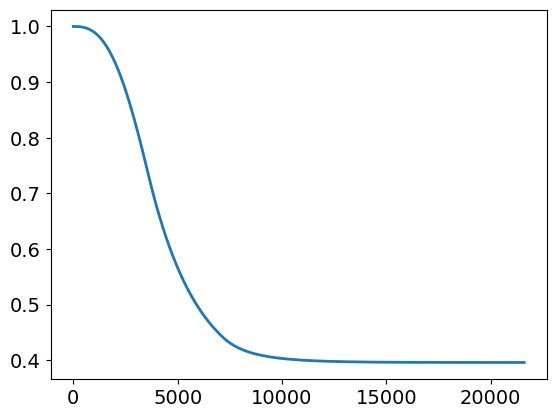

In [11]:
#Average SF for the 2D model
meansf = np.zeros(num)
for i in range(num):
  meansf[i] = np.mean(SF[:,:,i])

plt.plot(time,meansf)

<ipython-input-12-dc49adc346c1>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_custom = plt.cm.get_cmap('RdYlBu')


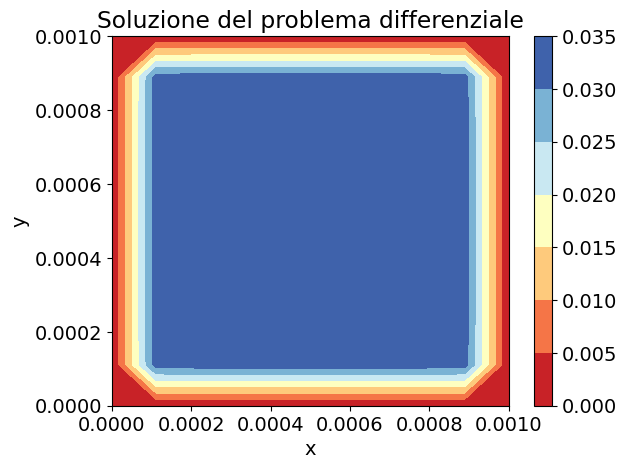

In [12]:
# Plot of ct
cmap_custom = plt.cm.get_cmap('RdYlBu')
plt.contourf(X, Y, c[:,:,5000], cmap=cmap_custom)
plt.colorbar()
plt.title('Soluzione del problema differenziale')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [13]:
# Other version of the 2D problem
import pdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from scipy.integrate import trapz
# Parametri della griglia
Lx, Ly = 0.001, 0.001  # Dimensioni del dominio spaziale
Nx, Ny = 10, 10  # Numero di nodi nella griglia
dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)  # Passi di spazio

# Inizializzazione della griglia
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)

# Inizializzazione della funzione c
c_ox = np.zeros((Nx, Ny, num + 1))
#area = np.zeros((Nx, Ny))
#aree = np.zeros((Nx, Ny, num + 1))
#SF = np.ones((Nx, Ny, num + 1))
#CM = np.zeros((Nx, Ny, num + 1))
flag = 0
# Iterazione temporale con il metodo delle differenze finite esplicite
for n in time:
  for i in range(1, Nx - 1):
    for j in range(1, Ny - 1):
      #suma = np.sum(aree[i,j,:])
      #SF[i,j,flag] = np.exp(-alpha * suma)
      laplacian_c = (c_ox[i + 1, j,flag] - 2 * c_ox[i, j,flag] + c_ox[i - 1, j,flag]) / dx**2 +  (c_ox[i, j + 1,flag] - 2 * c_ox[i, j,flag] + c_ox[i, j - 1,flag]) / dy**2
      c_ox[i, j,flag+1] = c_ox[i, j,flag] + passo * (D_ox * float(laplacian_c) + P_ox * SV * (float(c_v0_ox) - c_ox[i, j,flag]) - c_ox[i, j,flag] * (V_max_ox / (K_m_ox + c_ox[i, j, flag])))
      #CM[i,j, flag] = c_ox[i, j,flag] * (k_met * c_ox[i, j,flag] + V_max_tpz * c[i, j,flag]  / (K_m_tpz + c_ox[i, j,flag]))
      #area[i, j] = ((float(CM[i,j,flag]) + float(CM[i,j,flag-1]))*float(passo))/2
      #aree[i,j,flag] = area[i,j]
      #pdb.set_trace()
  flag = flag + 1

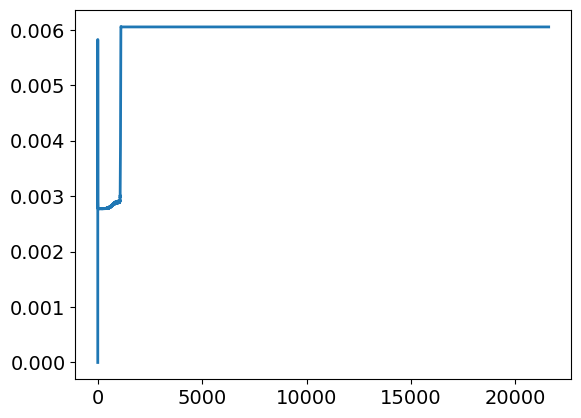

In [14]:

meanc_ox = np.zeros(num)
for i in range(num):
  meanc_ox[i] = np.mean(c_ox[:,:,i])

plt.plot(time,meanc_ox)

<ipython-input-15-dbd030d86ebb>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_custom = plt.cm.get_cmap('RdYlBu')


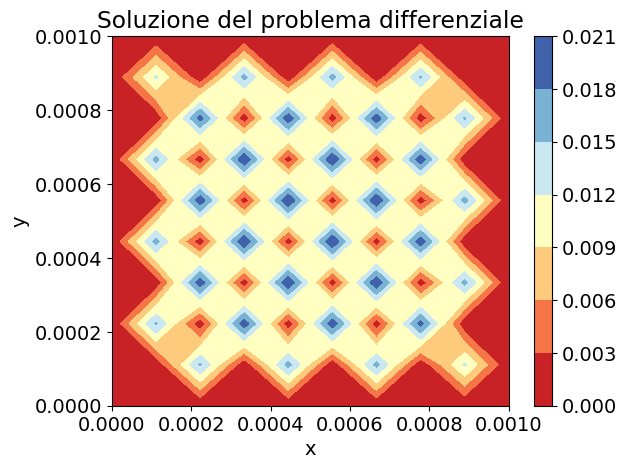

In [15]:
# Plot ct
cmap_custom = plt.cm.get_cmap('RdYlBu')
plt.contourf(X, Y, c_ox[:,:,5000], cmap=cmap_custom)
plt.colorbar()
plt.title('Soluzione del problema differenziale')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


Text(0, 0.5, 'Concentration mol/m^3')

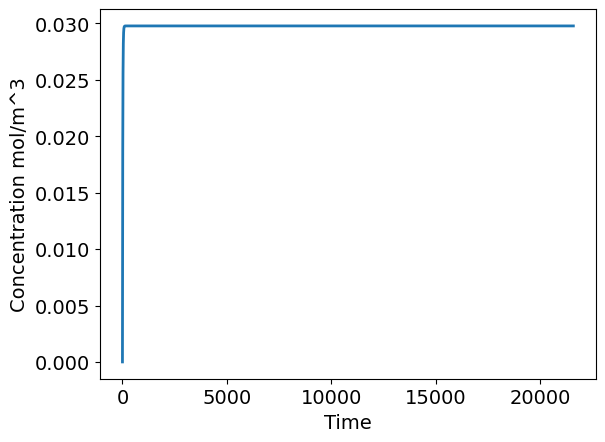

In [7]:
# Analitic solution of the simplified model with constant vascular concentration

def c_lin(c):
    return (-(B_l_tpz/A_l_tpz)* np.exp(-A_l_tpz*c) + B_l_tpz/A_l_tpz)


# Plot della soluzione lineare nel tempo
c_lin = c_lin(time)
consumo_l = time * c_lin * m_tpz
plt.plot(time,c_lin,label='ct linear consumption')
plt.xlabel('Time')
plt.ylabel('Concentration mol/m^3')

In [18]:
# Resolution of the problem with the varying vascular concentration, without consider the oxygen problem

import numpy as np
#Definition of the poroblem, c is the tissue concentration, suma is the integral of the tissue concentration, c_vv is the vascular concentration of the drug
def f(c, suma, c_vv):
    dcdt = -c * (K1_tpz - K2_tpz + K3_tpz) - (K / (K + O2)) * (k_met * c + (V_max_tpz * c) / (K_m_tpz + c)) * np.exp(-alpha * suma) * phi_0 + K2_tpz * c_vv + K3_tpz * c_vv
    return dcdt

c = [0.0]
c_vv = c_vv0

SF = []

aree = []
consumo_nl = [0.0]
m_app_cvvar = []
V_max_app_cvvar = []
flag = 0
consumo = []
consumosf = []
consumonoc = []
consumonocnosf = []
CM = [0.0]
for i in time:

    suma = np.sum(aree) # total integral for the SF
    c_temp = np.array([c[-1]]).astype(np.float64).flatten()
    c_temp = np.array(c_temp, dtype=np.float64) # ct at the last instant
    #Runge kutta parameters
    k1 = f(c_temp, suma,c_vv[flag])
    k2 = f((c[-1] + (k1 / 2)*passo).astype(np.float64), suma, c_vv[flag])
    k3 = f((c[-1] + (k2 / 2)*passo).astype(np.float64), suma, c_vv[flag])
    k4 = f((c[-1] + k3*passo).astype(np.float64), suma, c_vv[flag])
    c_temp = c[-1] + (passo / 6) * (k1 + 2 * k2 + 2 * k3 + k4) # ct calculated
    SF_temp = np.exp(-alpha * suma) 
    SF.append(SF_temp)
    c.append(c_temp)
    CM.append((K / (K + O2)) * c_temp * (k_met * c_temp + V_max_tpz * c_temp / (K_m_tpz + c_temp)))
    # consumo.append((K / (K + O2)) * (k_met * c_temp + V_max_tpz * c_temp / (K_m_tpz + c_temp)))
    # consumosf.append((K / (K + O2)) * (k_met * c_temp + V_max_tpz * c_temp / (K_m_tpz + c_temp)) * SF_temp)
    # consumonoc.append((K / (K + O2)) * (k_met  + V_max_tpz  / (K_m_tpz + c_temp)) * SF_temp)
    consumonocnosf.append((K / (K + O2)) * (k_met  + V_max_tpz  / (K_m_tpz + c_temp))) #metabolization rate r, not considering the SF and the tissue concentration
    area = ((float(CM[-1]) + float(CM[-2]))*float(passo))/2 #trapexoidal rule to calculate the integral to calculate the SF
    aree.append(area)
    flag = flag + 1



c_nlin_cvvar = c[1:]
SF_nlin_cvvar = SF

C:\Users\utente\AppData\Local\Temp\ipykernel_10084\4093355633.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  area = ((float(CM[-1]) + float(CM[-2]))*float(passo))/2 #trapexoidal rule to calculate the integral to calculate the SF


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


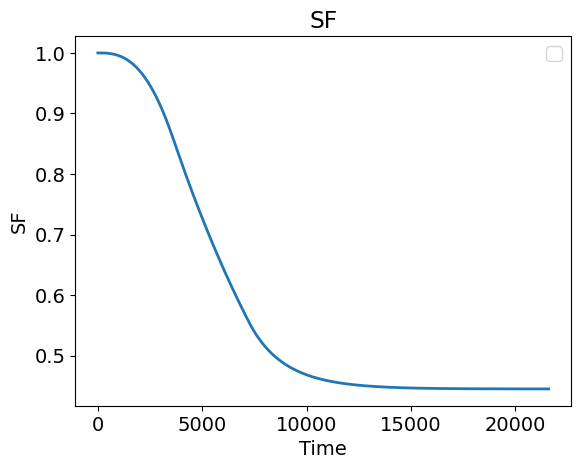

In [7]:
# SF
plt.plot(time,SF_nlin_cvvar)
plt.xlabel('Time')
plt.ylabel('SF')
plt.title('SF')
plt.legend()

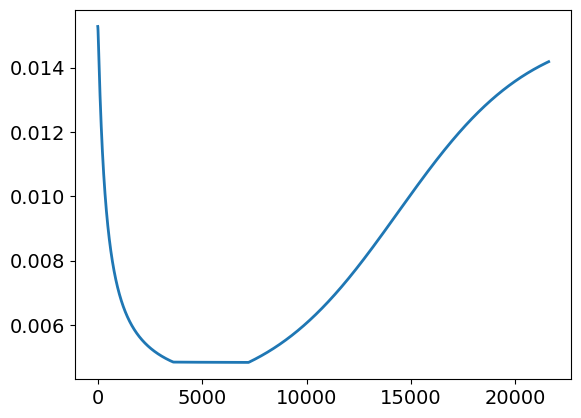

In [8]:
plt.plot(time,consumonocnosf) #

In [19]:
c_nlin_cvvar

[array([0.]),
 array([5.62739805e-07]),
 array([1.64994752e-06]),
 array([3.2259584e-06]),
 array([5.25753955e-06]),
 array([7.71372605e-06]),
 array([1.05656678e-05]),
 array([1.37864865e-05]),
 array([1.73511417e-05]),
 array([2.12363065e-05]),
 array([2.54202505e-05]),
 array([2.98827314e-05]),
 array([3.46048934e-05]),
 array([3.95691728e-05]),
 array([4.47592092e-05]),
 array([5.01597638e-05]),
 array([5.5756642e-05]),
 array([6.15366225e-05]),
 array([6.74873901e-05]),
 array([7.35974738e-05]),
 array([7.98561886e-05]),
 array([8.6253582e-05]),
 array([9.27803832e-05]),
 array([9.94279567e-05]),
 array([0.00010619]),
 array([0.00011305]),
 array([0.00012002]),
 array([0.00012707]),
 array([0.00013421]),
 array([0.00014144]),
 array([0.00014873]),
 array([0.0001561]),
 array([0.00016353]),
 array([0.00017102]),
 array([0.00017857]),
 array([0.00018617]),
 array([0.00019383]),
 array([0.00020153]),
 array([0.00020927]),
 array([0.00021705]),
 array([0.00022488]),
 array([0.00023274

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


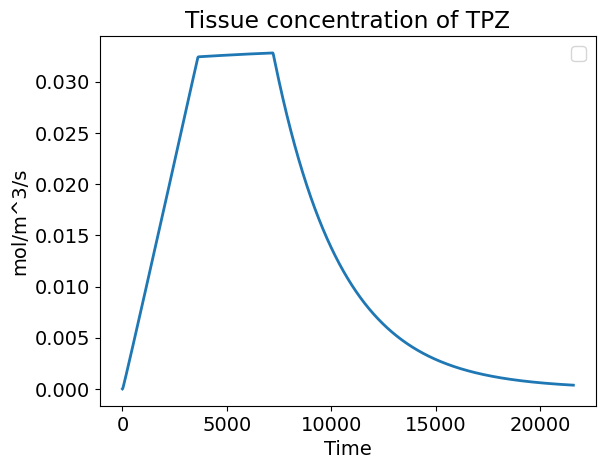

In [20]:
#ct
plt.plot(time,c_nlin_cvvar)
plt.xlabel('Time')
plt.ylabel('mol/m^3/s')
plt.title('Tissue concentration of TPZ')
plt.legend()

In [21]:
# Definition of the constants for the differential problem for the oxygen
K1_ox = 0
K2_ox = 0
K3_ox = (P_ox * D_ox)/(D_ox + P_ox * L) *SV
print(K1_ox)
print(K2_ox)
print(K3_ox)
A_ox = K1_ox - K2_ox + K3_ox
B_ox = (K2_ox + K3_ox)*c_v0_ox

0
0
0.1688688688688689


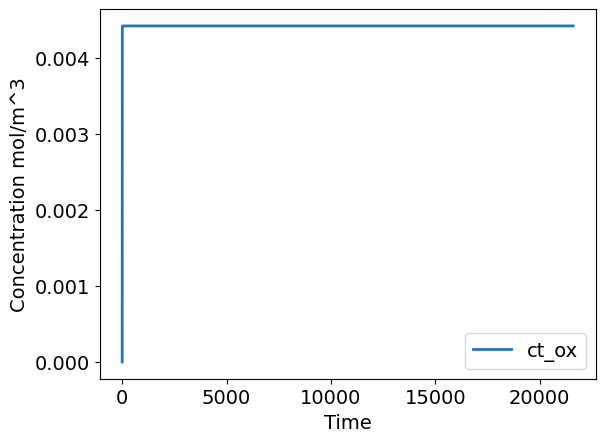

In [26]:
#Oxygen problem definition
def f_ox(c):
    dcdt = -c * (K1_ox - K2_ox + K3_ox+ (V_max_ox/(K_m_ox + c))) + (K2_ox * c_v0_ox + K3_ox * c_v0_ox)
    return dcdt
c = [0.0]
flag = 0

#Resolution with Runge Kutta
for i in time:
  c_temp = float(c[-1])
  k1 = f_ox(c_temp)
  k2 = f_ox((c[-1] + (k1 / 2)*passo))
  k3 = f_ox((c[-1] + (k2 / 2)*passo))
  k4 = f_ox((c[-1] + k3*passo))
  c_temp = c[-1] + (passo / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
  c.append(c_temp)
  flag = flag + 1

# Plot of the tissue concentration of oxygen
c_ox_lin = np.array(c)
plt.plot(time,c_ox_lin[0:-1],label='ct_ox')
plt.xlabel('Time')
plt.ylabel('Concentration mol/m^3')
plt.legend()

In [25]:
# Coupled problem for the drug and the oxygen, resolution through Runge Kutta method
import numpy as np
from scipy.integrate import trapz

K1_ox = 0.0
K2_ox = 0.0
K1_tpz = 0.0
K2_tpz = 0.0

def f_ox(c,SF):
    dcdt = -c * (K1_ox - K2_ox + K3_ox+ SF*(V_max_ox/(K_m_ox + c))) + (K2_ox * c_v0_ox + K3_ox * c_v0_ox)
    return dcdt
def f(c, suma, c_vv, ox):
    dcdt = -c * (K1_tpz - K2_tpz + K3_tpz) - (K / (K + ox)) * (k_met * c + (V_max_tpz * c) / (K_m_tpz + c)) * np.exp(-alpha * suma) * phi_0 + K2_tpz * c_vv + K3_tpz * c_vv
    return dcdt

# considerando 2h cresce linearmente per 50% del tempo, costante per 1h e decrescente esponenzialmente
c = [0.0]
c_vv = c_vv0
# num = int((fine - inizio) / passo)
SF = []
# time = np.linspace(inizio, fine, num)
aree = []
consumo_nl = [0.0]
m_app_cvvar = []
V_max_app_cvvar = []
flag = 0
consumo = []
consumosf = []
consumonoc = []
consumonocnosf = []

CM = [0.0]
c_ox = [0.0042344]
for i in time:

    suma = trapz(CM)
    c_temp = float(c[-1])
    k1 = f(c_temp, suma,c_vv[flag],c_ox[-1])
    k2 = f((c[-1] + (k1 / 2)*passo).astype(np.float64), suma, c_vv[flag],c_ox[-1])
    k3 = f((c[-1] + (k2 / 2)*passo).astype(np.float64), suma, c_vv[flag],c_ox[-1])
    k4 = f((c[-1] + k3*passo).astype(np.float64), suma, c_vv[flag],c_ox[-1])
    c_temp = c[-1] + (passo / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    SF_temp = np.exp(-alpha * suma)
    SF.append(SF_temp)
    c.append(c_temp)
    CM.append((K / (K + c_ox[-1])) * c_temp * (k_met * c_temp + V_max_tpz * c_temp / (K_m_tpz + c_temp)))
    consumo.append((K / (K + c_ox[-1])) * (k_met * c_temp + V_max_tpz * c_temp / (K_m_tpz + c_temp)))
    consumosf.append((K / (K + c_ox[-1])) * (k_met * c_temp + V_max_tpz * c_temp / (K_m_tpz + c_temp)) * SF_temp)
    consumonoc.append((K / (K + c_ox[-1])) * (k_met  + V_max_tpz  / (K_m_tpz + c_temp)) * SF_temp)
    consumonocnosf.append((K / (K + c_ox[-1])) * (k_met  + V_max_tpz  / (K_m_tpz + c_temp)) * phi_0)
    area = ((float(CM[-1]) + float(CM[-2]))*float(passo))/2
    aree.append(suma)

    c_temp_ox = float(c_ox[-1])
    k1_ox = f_ox(c_temp_ox,float(SF_temp))
    k2_ox = f_ox((c_ox[-1] + (k1_ox / 2)*passo),float(SF_temp))
    k3_ox = f_ox((c_ox[-1] + (k2_ox / 2)*passo),float(SF_temp))
    k4_ox = f_ox((c_ox[-1] + k3_ox*passo),float(SF_temp))
    c_temp_ox = c_ox[-1] + (passo / 6) * (k1_ox + 2 * k2_ox + 2 * k3_ox + k4_ox)
    c_ox.append(c_temp_ox)
    flag = flag + 1



c_nlin_cvvar_ox = c
SF_nlin_cvvar_ox = SF

C:\Users\utente\AppData\Local\Temp\ipykernel_10084\1980488599.py:37: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  suma = trapz(CM)


Text(0, 0.5, 'SF')

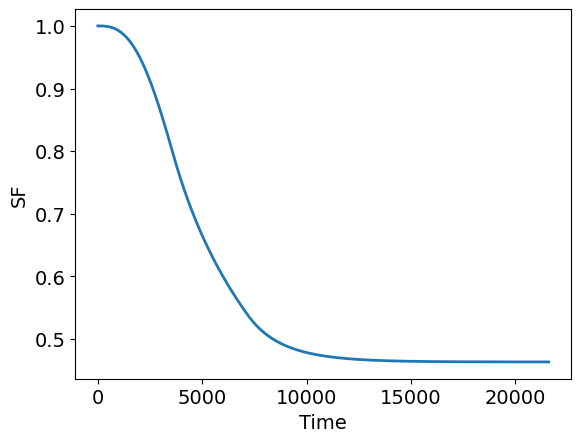

In [26]:
# SF
plt.plot(time,SF_nlin_cvvar_ox)
plt.xlabel('Time')
plt.ylabel('SF')

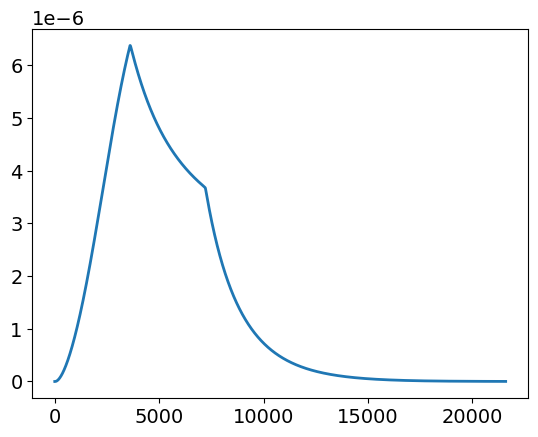

In [28]:
# Cumulative metabolism (integrated)
plt.plot(time,CM[0:-1])

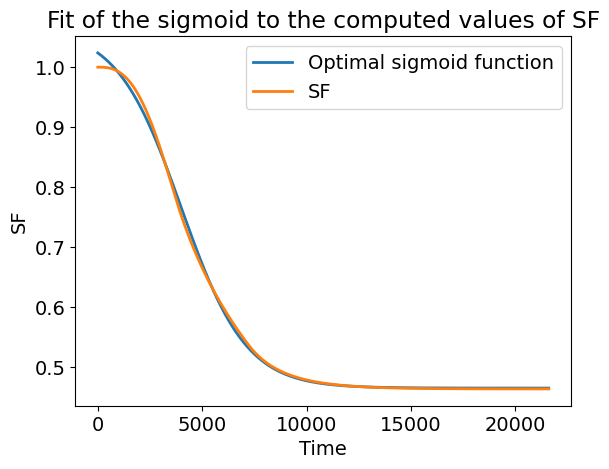

In [31]:
# Fitting the SF as a sigmoid
SF_nlin_cvvar_ox = np.array(SF_nlin_cvvar_ox)

m_app_cvvar = np.array(m_app_cvvar)
# SIgmoid function
def sigm(t,X,Y,Z,D):
  s = X - ((Y)/(1 + np.exp(-Z * (t - D))))
  return s

# Initialization of the parameters
X = max(SF_nlin_cvvar_ox)
Y = X - min(SF_nlin_cvvar_ox)
Z = 0.0005
D = len(time)/2

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt



params, covariance = curve_fit(sigm, time, SF_nlin_cvvar_ox, p0=[X, Y, Z, D])

XX, YY, ZZ, DD = params

sol = sigm(time,XX,YY,ZZ,DD)
plt.rc('font', size=14)
plt.rcParams['lines.linewidth'] = 2
plt.plot(time,sol,label='Optimal sigmoid function')
plt.plot(time,SF_nlin_cvvar_ox,label='SF')
plt.xlabel('Time')
plt.ylabel('SF')
plt.title('Fit of the sigmoid to the computed values of SF')
plt.legend()


In [12]:
# residual
residual = abs(sol - SF_nlin_cvvar_ox)
''' plt.plot(time,residual)
max(residual) * 100 '''

' plt.plot(time,residual)\nmax(residual) * 100 '

In [32]:
# Test for the goodness of fit
from scipy import stats
from scipy.stats import chisquare
from sklearn.metrics import r2_score
import scipy.stats as stats
from scipy.optimize import curve_fit

observed_data = np.array(SF_nlin_cvvar_ox)
predicted_data = np.array(sol)


#Test chi squared
chi_squared, p_value = chisquare(f_obs=observed_data, f_exp=predicted_data)
print("Chi-squared:", chi_squared)
print("p-value:", p_value)


# Test R2
r_squared = r2_score(observed_data, predicted_data)
print("R-squared:", r_squared)


# Test kolmogorov smirnov 
statistic, pvalue = stats.kstest(observed_data, predicted_data)
obj = stats.kstest(observed_data, predicted_data)
# Stampiamo il risultato del test
print("Statistic:", statistic)
print("P-value:", pvalue)

Chi-squared: 0.8474005526575528
p-value: 1.0
R-squared: 0.9989987807880943
Statistic: 0.3334259259259259
P-value: 0.0


In [33]:
# Sigmoid parameters
print(XX)
print(YY)
print(ZZ)
print(DD)

1.0657924220204655
0.6012709149960392
0.0006466941222005291
4002.4812937446773


Text(0.5, 1.0, 'Rate of consumption m')

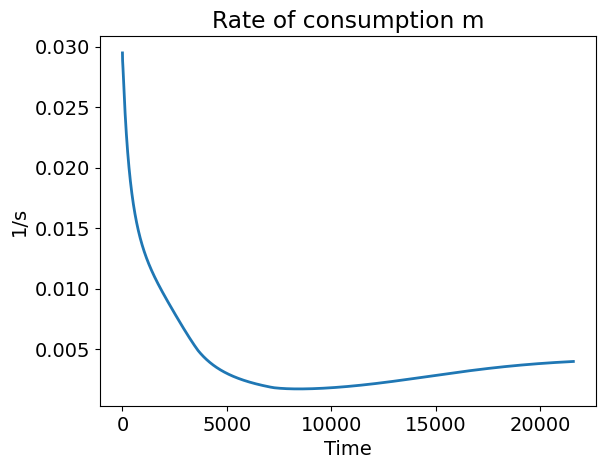

In [34]:
plt.plot(time,consumonoc) #((K / (K + c_ox[-1])) * (k_met  + V_max_tpz  / (K_m_tpz + c_temp)) * SF_temp)
plt.xlabel('Time')
plt.ylabel('1/s')
plt.title('Rate of consumption m')

Text(0.5, 1.0, 'Drug concentration in the tissue for the coupled problem')

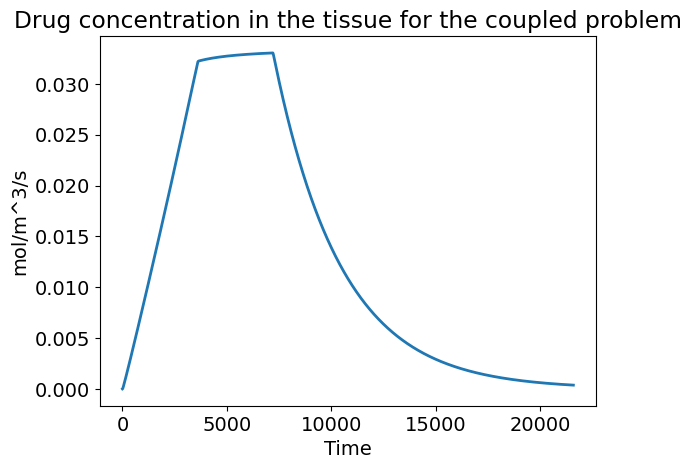

In [35]:
# Tissue concentration of the drug
plt.plot(time,c_nlin_cvvar_ox[0:-1])
plt.xlabel('Time')
plt.ylabel('mol/m^3/s')
plt.title('Drug concentration in the tissue for the coupled problem')

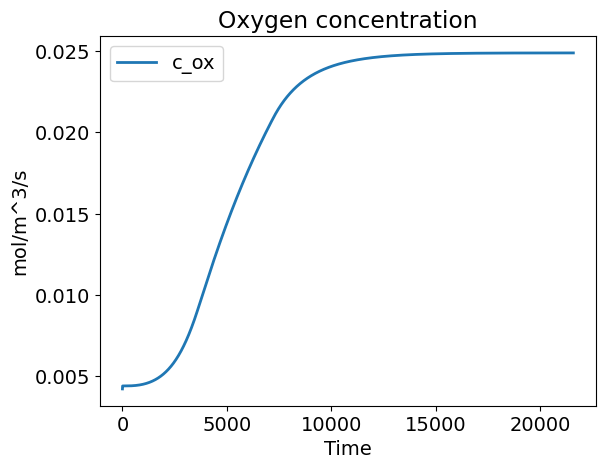

In [36]:
# Oxygen concentration in the tissue
plt.plot(time,c_ox[0:-1], label='c_ox')
plt.xlabel('Time')
plt.ylabel('mol/m^3/s')
plt.title('Oxygen concentration')
plt.legend()

Text(0.5, 1.0, 'Rate of consumption r')

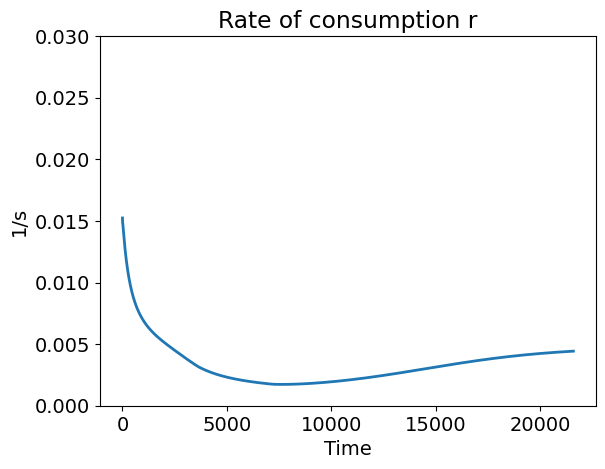

In [37]:
plt.plot(time,consumonocnosf) #parameter r modeled ((K / (K + c_ox[-1])) * (k_met  + V_max_tpz  / (K_m_tpz + c_temp)))
#plt.plot(time,iperbole(time,10,0,0.005))
plt.ylim(0,0.03)
plt.xlabel('Time')
plt.ylabel('1/s')
plt.title('Rate of consumption r')

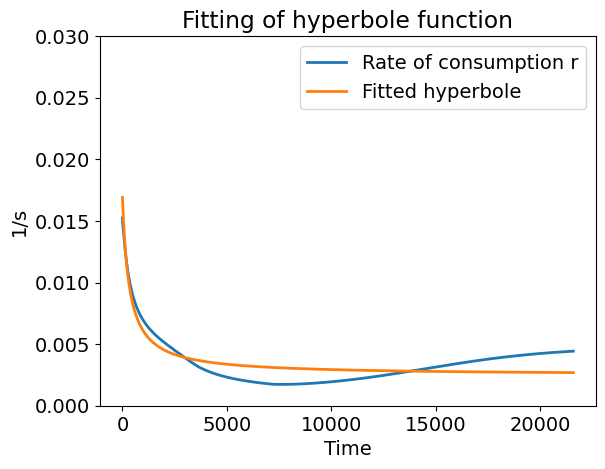

In [41]:
# Fit of r with an hyperbolic function
from scipy.optimize import curve_fit
def iperbole(x, a, b, cc):
    return a / (x + b) + cc

consumonocnosf = np.array(consumonocnosf) #(K / (K + c_ox[-1])) * (k_met  + V_max_tpz  / (K_m_tpz + c_temp))
consumonocnosf = consumonocnosf.flatten()
consumonocnosf.shape


params, covariance = curve_fit(iperbole, time, consumonocnosf)


a, b, cc = params


curve_fit_consumonocnosf = iperbole(time, a, b, cc)

# plot
plt.plot(time, consumonocnosf, label='Rate of consumption r')
plt.plot(time, curve_fit_consumonocnosf, label='Fitted hyperbole')
plt.legend()
plt.xlabel('Time')
plt.ylabel('1/s')
plt.title('Fitting of hyperbole function')
plt.ylim(0,0.03)
plt.show()

In [42]:
#Goodness of fit tests
from scipy import stats
from scipy.stats import chisquare
from sklearn.metrics import r2_score
import scipy.stats as stats
from scipy.optimize import curve_fit

observed_data = np.array(consumonocnosf)
predicted_data = np.array(curve_fit_consumonocnosf)



# r squared
r_squared = r2_score(observed_data, predicted_data)
print("R-squared:", r_squared)


# kolmogorov smirnov
statistic, pvalue = stats.kstest(observed_data, predicted_data)
obj = stats.kstest(observed_data, predicted_data)
# Results
print("Statistic:", statistic)
print("P-value:", pvalue)

R-squared: 0.6996513952937929
Statistic: 0.42148148148148146
P-value: 0.0


In [43]:
# Parmeterfs of the hyperbole
print(a)
print(b)
print(cc)

4.786454999003923
331.6163250967257
0.0024698791454990866


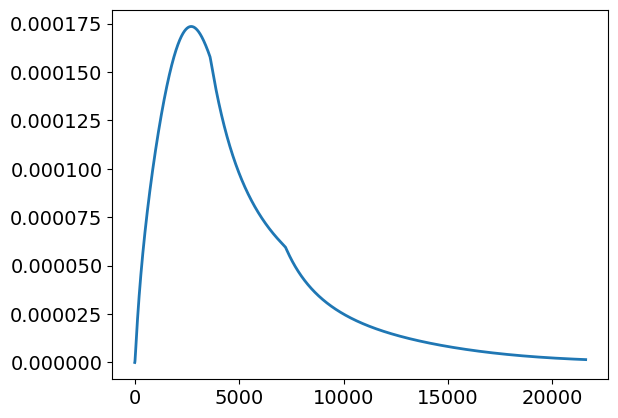

In [44]:
# Other parametrization of the consumption (not used)
plt.plot(time,consumosf) 

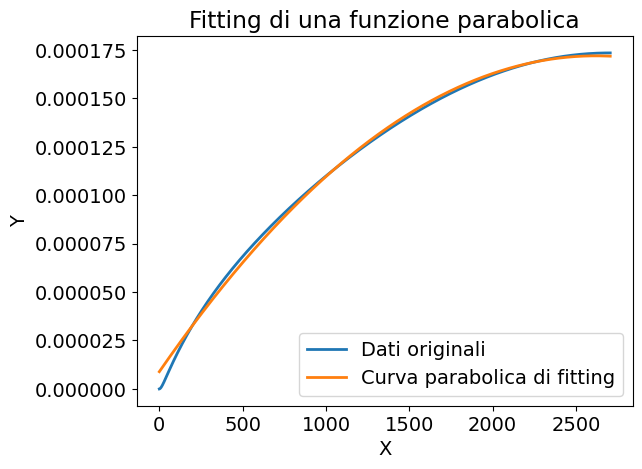

In [45]:
def parabola(x, a, b, cc):
    return a * x**2 + b * x + cc

consumosf = np.array(consumosf)
consumosf = consumosf = np.array(consumosf).flatten()
# Esegue il fitting della curva
params, covariance = curve_fit(parabola, time[0:2707], consumosf[0:2707])

# Estrae i parametri della parabola
a, b, cc = params

# Genera una curva parabolica utilizzando i parametri ottenuti
curve_fit_consumosf1 = parabola(time[0:2707], a, b, cc)

# Visualizza i dati e la curva parabolica
plt.plot(time[0:2707], consumosf[0:2707], label='Dati originali')
plt.plot(time[0:2707], curve_fit_consumosf1, label='Curva parabolica di fitting')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Fitting di una funzione parabolica')
plt.show()

C:\Users\utente\AppData\Local\Temp\ipykernel_10084\1894297692.py:2: RuntimeWarning: overflow encountered in exp
  return b * np.exp(-x * a + cc)


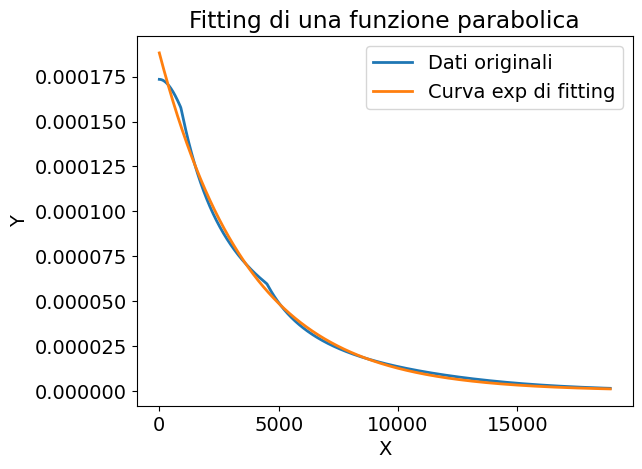

In [46]:
def expdec(x, a, b, cc):
    return b * np.exp(-x * a + cc)

time2 = range(0,int(len(time) - 2707))
time2 = np.array(time2)
time2.shape
consumosf2 = consumosf[2707:]
consumosf2.shape

# Esegue il fitting della curva
params, covariance = curve_fit(expdec, time2, consumosf2)

# Estrae i parametri della parabola
a, b, cc= params

# Genera una curva parabolica utilizzando i parametri ottenuti
curve_fit_consumosf2 = expdec(time2, a, b, cc)

# Visualizza i dati e la curva parabolica
plt.plot(time2, consumosf2, label='Dati originali')
plt.plot(time2, curve_fit_consumosf2, label='Curva exp di fitting')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Fitting di una funzione parabolica')
plt.show()

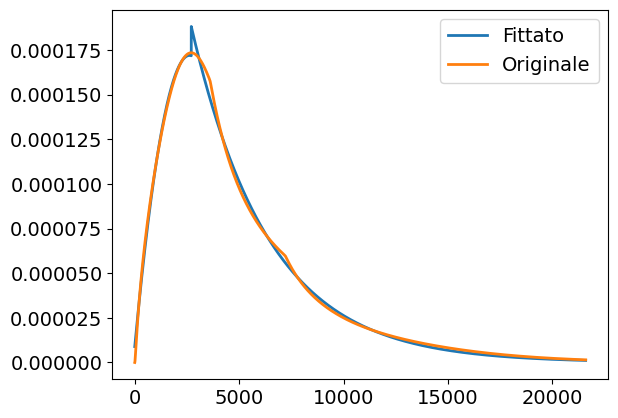

In [47]:
consumosftot = np.concatenate((curve_fit_consumosf1, curve_fit_consumosf2), axis=0)
plt.plot(time,consumosftot, label='Fittato')
plt.plot(time,consumosf, label = 'Originale')
plt.legend()

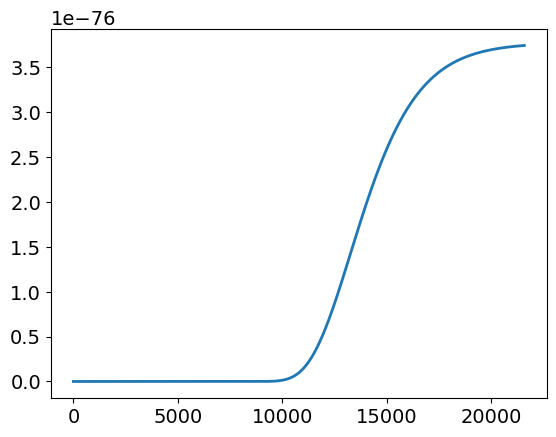

In [49]:
#TCP not used
SF_nlin_cvvar_ox = np.array(SF_nlin_cvvar_ox)
def TCP(cell_density, volume, SF):
    return np.exp(-cell_density * volume * SF)

cell_density = 3E6 #cell/cm^3
volume = 1.25E-4 #cm^3

TCP_1 = TCP(cell_density, volume, SF_nlin_cvvar_ox)


plt.plot(time,TCP_1)

In [44]:
''' plt.figure(figsize=(70, 70))
plt.rc('font', size=30)
plt.rcParams['lines.linewidth'] = 4
righe = 5
colonne = 3
plt.subplot(righe,colonne,1)
plt.plot(time,SF_nlin_cvvar_ox)
plt.xlabel('Time')
plt.ylabel('SF')

plt.subplot(righe,colonne,2)
plt.plot(time,sol,label='Sigmoid')
plt.plot(time,SF_nlin_cvvar_ox,label='SF')
plt.legend()

plt.subplot(righe,colonne,3)
plt.plot(time,sol,label='Optimal sigmoid function')
plt.plot(time,SF_nlin_cvvar_ox,label='SF')
plt.xlabel('Time')
plt.ylabel('SF')
plt.legend()

plt.subplot(righe,colonne,4)
plt.plot(time,residual)

plt.subplot(righe,colonne,5)
plt.plot(time,c_nlin_cvvar_ox[0:-1])
plt.xlabel('Time')
plt.ylabel('mol/m^3/s')

plt.subplot(righe,colonne,6)
plt.plot(time,c_ox[0:-1])
plt.xlabel('Time')
plt.ylabel('mol/m^3')

plt.subplot(righe,colonne,7)
plt.plot(time,consumonoc) #((K / (K + c_ox[-1])) * (k_met  + V_max_tpz  / (K_m_tpz + c_temp)) * SF_temp)
plt.xlabel('Time')
plt.ylabel('1/s')


plt.subplot(righe,colonne,8)
plt.plot(time,consumonocnosf) #da modellizzare ((K / (K + c_ox[-1])) * (k_met  + V_max_tpz  / (K_m_tpz + c_temp)))
#plt.plot(time,iperbole(time,10,0,0.005))
plt.ylim(0,0.06)

plt.subplot(righe,colonne,9)
plt.plot(time, consumonoc, label='Dati originali')
plt.plot(time, curve_fit_consumonoc, label='Curva iperbolica di fitting')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Fitting di una funzione iperbolica')
plt.ylim(0,0.06)


plt.subplot(righe,colonne,10)
plt.plot(time, consumonocnosf, label='Dati originali')
plt.plot(time, curve_fit_consumonocnosf, label='Curva iperbolica di fitting')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Fitting di una funzione iperbolica')
plt.ylim(0,0.06)
#plt.xlim(-10,1000)


plt.subplot(righe,colonne,11)
plt.plot(time,consumosf) #da modellizzare

plt.subplot(righe,colonne,12)
plt.plot(time[0:2707], consumosf[0:2707], label='Dati originali')
plt.plot(time[0:2707], curve_fit_consumosf1, label='Curva parabolica di fitting')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Fitting di una funzione parabolica')


plt.subplot(righe,colonne,13)
plt.plot(time2, consumosf2, label='Dati originali')
plt.plot(time2, curve_fit_consumosf2, label='Curva exp di fitting')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Fitting di una funzione parabolica')


plt.subplot(righe,colonne,14)
plt.plot(time,consumosftot, label='Fittato')
plt.plot(time,consumosf, label = 'Originale')
plt.legend()

plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

SyntaxError: ignored